In [1]:
import torch
from mod.model import MODiffuser
from diffuser import utils
import pickle

pybullet build time: Nov 28 2023 23:51:11


In [2]:
# Load diffuser, Unet
path = '../experiment_runs/mod_impl4/generalize/mixup_num/5/mod/naive/bc/MO-Hopper-v3/expert_custom_large/1/ckpt/step=200000.ckpt'

device = torch.device('cuda:0')
class Parser():
    config: str = "config.locomotion"
    savepath: str = "../experiment_runs/mod_analysis/",
    horizon: int = 8
    n_diffusion_steps:int = 8
    device: int = 0
    
diffuser_args = Parser()

diffuser = MODiffuser( # parameter here dosen't matter
    state_dim=17,
    act_dim=6,
    pref_dim=2,
    hidden_size=512,
    max_length=8,
    eval_context_length=5,
    max_ep_len=500,
    act_scale=1,
    scale=1000,
    use_pref=1,
    concat_state_pref=0,
    concat_act_pref=0,
    concat_rtg_pref=0,
    diffuser_args=diffuser_args,
    mod_type='bc',
    infer_N=7,
    cond_M=1,
    batch_size=64,
    returns_condition=False,
    condition_guidance_w=0.1,
    concat_on='r', 
    verbose=False,
    warmup_steps=10000,
    id_prefs=None,
    mixup_step=100000,
    mixup_num=8,
    loading=True, # Just set this to True
)
diffuser.load_model(path, device_idx=0, evaluate=True)
unet = diffuser.diffusion.model

Loading models from ../experiment_runs/mod_impl4/generalize/mixup_num/5/mod/naive/bc/MO-Hopper-v3/expert_custom_large/1/ckpt/step=200000.ckpt


In [3]:
# Load dataset
env = "Hopper"
horizon = 8
data_path = f'/home/amax/xyc/D4MORL/data_generation/data_collected/MO-{env}-v3/MO-{env}-v3_50000_newexpert_uniform.pkl'
trajs = []
with open(data_path, 'rb') as f:
    trajs = pickle.load(f)
    
import numpy as np
idx = np.random.randint(0, 50000, 1)

obs, act, pref = [], [] ,[]

for i in idx:
    obs.append(trajs[i]['observations'])
    act.append(trajs[i]['actions'])
    pref.append(trajs[i]['preference'])
    
traj_max_len = np.max([len(s) for s in obs])
for items in [obs, act, pref]:
    for i, s in enumerate(items):
        if len(s) < traj_max_len:
            items[i] = np.pad(s, ((0, traj_max_len - len(s)), (0, 0)), mode='constant')
obs, act, pref = np.array(obs), np.array(act), np.array(pref)

obs_slice, act_slice, pref_slice = [], [], []

idx = np.random.randint(0, 500 - horizon, 10)

for i in idx:
    obs_slice.extend(obs[:, i:i+horizon])
    act_slice.extend(act[:, i:i+horizon])
    pref_slice.extend(pref[:, i:i+horizon])
    
obs_slice = np.array(obs_slice)
act_slice = np.array(act_slice)
pref_slice = np.array(pref_slice)

as_traj = np.concatenate([act_slice, obs_slice], axis=-1)
pref_traj = pref_slice[:, 0, :]

print(as_traj.shape, pref_traj.shape)

(10, 8, 14) (10, 3)


In [4]:
# Jacobian Analysis
from analysis.jacobian import calc_jacobian

idxs = [0]
inp = torch.from_numpy(as_traj[idxs]).to(device, dtype=torch.float32) # B x H x T
prefs = torch.from_numpy(pref_traj[idxs]).to(device, dtype=torch.float32)
K = as_traj.shape[1] * as_traj.shape[2]
I = torch.eye(K).to(device)
J = calc_jacobian(inp, prefs, unet)
U, S, V = torch.svd(J)

prefs

tensor([[0.3559, 0.0915, 0.5526]], device='cuda:0')

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 [Text(1, -0.5, '−0.5'),
  Text(1, 0.0, '0.0'),
  Text(1, 0.5, '0.5'),
  Text(1, 1.0, '1.0'),
  Text(1, 1.5, '1.5'),
  Text(1, 2.0, '2.0'),
  Text(1, 2.5, '2.5'),
  Text(1, 3.0, '3.0'),
  Text(1, 3.5, '3.5'),
  Text(1, 4.0, '4.0'),
  Text(1, 4.5, '4.5')])

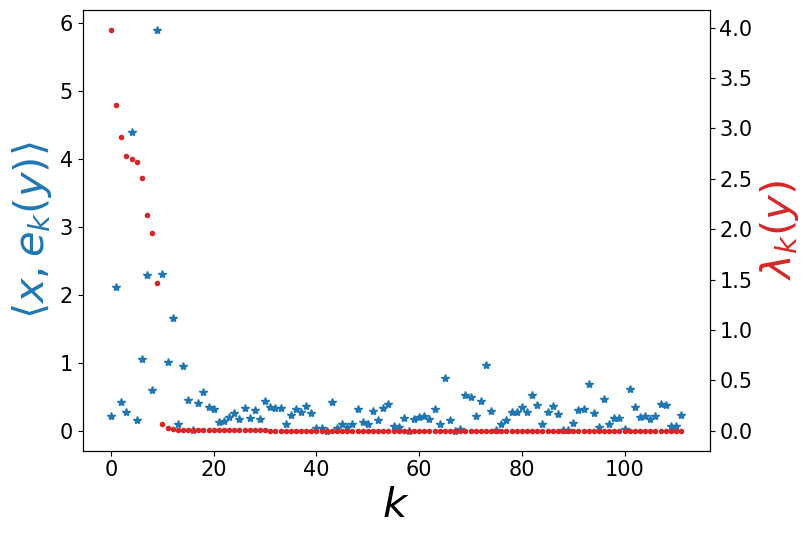

In [5]:
import matplotlib.pyplot as plt

cors = []
for j in range(K): 
    cors.append( torch.dot(U[:,j], inp.flatten() ).detach().cpu() )
cors = torch.stack(cors)  

f, ax1 = plt.subplots(1,1, figsize = (7,5), sharey=False )
plt.tight_layout()

color = 'tab:blue'
ax1.set_xlabel(r'$k$', fontsize=30)
ax1.plot(abs(cors.cpu()), '*', label = r'$ \langle x,e_k\rangle $', alpha = 1)
ax1.set_ylabel(r'$\langle x,e_k(y)\rangle $', color=color,fontsize = 30)
plt.xticks( fontsize = 15)
plt.yticks( fontsize = 15)

color = 'tab:red'
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$\lambda_k(y)$', color=color, fontsize = 30, rotation=90)
ax2.plot(S.cpu(), '.', alpha = 1, color=color)
plt.yticks( fontsize = 15)